# Colab Setup

This notebook requires a GPU runtime.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%bash

# git clone https://github.com/explanare/ravel.git
# git clone https://github.com/stanfordnlp/pyvene.git

# pip install accelerate
# pip install datasets

# cd pyvene
# git checkout d29f9591ca61753d66ba25f6cc3a4c05bab48480

In [2]:
%cd /home/b289zhan/projects/ravel/

/home/b289zhan/projects/ravel


In [3]:
import numpy as np
import random
import sys
import torch

RAVEL_LIB_DIR = '/home/b289zhan/projects/ravel/src'
RAVEL_SCRIPT_DIR = '/home/b289zhan/projects/ravel/scripts'
PYVENE_LIB_DIR = '/home/b289zhan/projects/pyvene'

sys.path.append(RAVEL_LIB_DIR)
sys.path.append(RAVEL_SCRIPT_DIR)
sys.path.append(PYVENE_LIB_DIR)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# !mkdir models
# !mkdir data

MODEL_DIR = '/home/b289zhan/projects/ravel/models'
DATA_DIR = '/home/b289zhan/projects/ravel/data'

# Model

In [4]:
from transformers import AutoConfig, LlamaForCausalLM, AutoTokenizer

model_id = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir=MODEL_DIR)
model = LlamaForCausalLM.from_pretrained(
    model_id, 
    low_cpu_mem_usage=True, 
    device_map='auto', 
    cache_dir=MODEL_DIR,
    dtype=torch.bfloat16
)
model = model.eval()
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

VOCAB = sorted(tokenizer.vocab, key=tokenizer.vocab.get)

/home/b289zhan/anaconda3/envs/ravel/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

**Download the RAVEL-TinyLlama instance (tinyllama.tgz) from [Google Drive](https://drive.google.com/file/d/1Vyet8flNLiL_nOKTy-BsDCr35zX730Ol/view?usp=sharing)**. The instance contains four files:

* Training data for DAS & MDAS: [`tinyllama_city_train.json`](https://drive.google.com/file/d/1NWdEjkisvN_1p7fGg7qwgEAQkfJhjSrQ/view?usp=drive_link)

* Entity val/test data: [`tinyllama_city_entity_test.json`](https://drive.google.com/file/d/1kXGuL_Picc4aHuTc2XpyaLBZFaji0bxC/view?usp=drive_link)

* Context val/test data: [`tinyllama_city_context_test.json`](https://drive.google.com/file/d/1c8VPfg4dHDwtej31lB9DFEpI31loBBCb/view?usp=drive_link)

* Intervention locations: [`tinyllama_city_prompt_to_entity_position.json`](https://drive.google.com/file/d/1DtAfnSKMRso7RAphjkp3hMjvFw7HcazB/view?usp=drive_link)


In [ ]:
# %%bash

# tar -xzf tinyllama.tgz -C data/
# mkdir data/base
# tar -xvf data.tgz -C data/base --strip-components=1

In [5]:
import json
import os
import random

import datasets
from datasets import Dataset


instance = 'tinyllama'
entity_type = 'city'
INPUT_MAX_LEN = 48
FEATURE_TYPES = datasets.Features({
    "input": datasets.Value("string"),
    "label": datasets.Value("string"),
    "source_input": datasets.Value("string"),
    "source_label": datasets.Value("string"),
    "inv_label": datasets.Value("string"),
    'split': datasets.Value("string"),
    'source_split': datasets.Value("string"),
    'entity': datasets.Value("string"),
    'source_entity': datasets.Value("string")
})

# Load training dataset.
split_to_raw_example = json.load(open(os.path.join(DATA_DIR, f'{instance}/{instance}_{entity_type}_train.json'), 'r'))
# Load validation + test dataset.
split_to_raw_example.update(json.load(open(os.path.join(DATA_DIR, f'{instance}/{instance}_{entity_type}_context_test.json'), 'r')))
split_to_raw_example.update(json.load(open(os.path.join(DATA_DIR, f'{instance}/{instance}_{entity_type}_entity_test.json'), 'r')))
# Prepend an extra token to avoid tokenization changes for Llama tokenizer.
# Each sequence will start with <s> _ 0
SOS_PAD = '0'
NUM_SOS_TOKENS = 3
for split in split_to_raw_example:
  for i in range(len(split_to_raw_example[split])):
    split_to_raw_example[split][i]['inv_label'] = SOS_PAD + split_to_raw_example[split][i]['inv_label']
    split_to_raw_example[split][i]['label'] = SOS_PAD + split_to_raw_example[split][i]['label']


# Load attributes (tasks) to prompt mapping.
ALL_ATTR_TO_PROMPTS = json.load(open(os.path.join(DATA_DIR, 'base', f'ravel_{entity_type}_attribute_to_prompts.json')))

# Load prompt to intervention location mapping.
split_to_entity_pos = json.load(open(os.path.join(DATA_DIR, instance, f'{instance}_{entity_type}_prompt_to_entity_position.json')))
SPLIT_TO_INV_LOCATIONS = {
    f'{task}{split}': {'max_input_length': INPUT_MAX_LEN,
                       'inv_position': [INPUT_MAX_LEN + pos]}
    for task, pos in split_to_entity_pos.items()
    for split in ('-train', '-test', '-val', '')
}
assert(min([min(v['inv_position']) for v in SPLIT_TO_INV_LOCATIONS.values()]) > 0)


# Preprocess the dataset.
def filter_inv_example(example):
  return (example['label'] != example['inv_label'] and
          example['source_split'] in SPLIT_TO_INV_LOCATIONS and
          example['split'] in SPLIT_TO_INV_LOCATIONS)


for split in split_to_raw_example:
  random.shuffle(split_to_raw_example[split])
  split_to_raw_example[split] = list(filter(filter_inv_example, split_to_raw_example[split]))
  if len(split_to_raw_example[split]) == 0:
    print('Empty split: "%s"' % split)
# Remove empty splits.
split_to_raw_example = {k: v for k, v in split_to_raw_example.items() if len(v) > 0}
print(f"#Training examples={sum(map(len, [v for k, v in split_to_raw_example.items() if k.endswith('-train')]))}, "
      f"#Validation examples={sum(map(len, [v for k, v in split_to_raw_example.items() if k.endswith('-val')]))}, "
      f"#Test examples={sum(map(len, [v for k, v in split_to_raw_example.items() if k.endswith('-test')]))}")
split_to_dataset = {split: Dataset.from_list(
    split_to_raw_example[split], features=FEATURE_TYPES)
                    for split in split_to_raw_example}

# #Training examples=116728, #Validation examples=20516, #Test examples=22497

#Training examples=116728, #Validation examples=20516, #Test examples=22497


# Sparse Autoencoder (SAE)

## Training

We will train a sparse autoencoder on entity representations extracted offline.

* Download entity representations extracted from the Wikipedia dataset [here](https://drive.google.com/file/d/1hZ-Nv3ehf0Ok4ic3ybe-DATEh-HRjYkt/view?usp=drive_link)

In [6]:
from utils.dataset_utils import HDF5Dataset


file_path = os.path.join(DATA_DIR, "wikipedia_20220301_city_tinyllama_layer14_features_200k.hdf5")
TRAINING_BATCH_SIZE = 32
train_dataset = HDF5Dataset(file_path, sample_range=None)
val_dataset = HDF5Dataset(file_path, sample_range=list(range(80, 128)))
wiki_train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=True)
wiki_val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=TRAINING_BATCH_SIZE, shuffle=True)

# #Entities=3456, #Examples=234919
# Load 234919 examples
# #Entities=3456, #Examples=234919
# Load 37567 examples

#Entities=3456, #Examples=234919
Load 234919 examples
#Entities=3456, #Examples=234919
Load 37567 examples


In [7]:
task_name = 'tinyllama-layer14-dim8192-reg0.5-ep5-sae-city_wikipedia_200k' #@param
task_name

'tinyllama-layer14-dim8192-reg0.5-ep5-sae-city_wikipedia_200k'

In [ ]:
import re

from train_sae import train_sae


config = {
    'task_name': task_name,
    'reg_coeff': float(re.search('reg([\d.]+)', task_name).group(1)),
    'input_dim': model.config.hidden_size,
    'latent_dim': int(re.search('dim(\d+)', task_name).group(1)),
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'end_learning_rate_ratio': 0.5,
    'num_epochs': int(re.search('ep(\d+)', task_name).group(1)),
    'model_dir': MODEL_DIR,
    'log_dir': os.path.join(MODEL_DIR, 'logs', task_name),
}

# Training metrics are logged to the Tensorboard at http://localhost:6006/.
autoencoder = train_sae(config, wiki_train_dataloader, wiki_val_dataloader)

## Feature Selection

In [11]:
import torch
from methods.sparse_autoencoder import SparseAutoencoder

autoencoder_run_name = 'tinyllama-layer14-dim8192-reg0.5-ep5-sae-city_wikipedia_200k.pt'
ckpt_path = os.path.join(MODEL_DIR, autoencoder_run_name)
# autoencoder = torch.load(ckpt_path).to(device)
autoencoder = torch.load(ckpt_path, weights_only=False).to(device)

In [12]:
# Load the RAVEL dataset.
import json

from utils.dataset_utils import load_entity_representation_with_label

entity_type = 'city'
layer = 14
print(entity_type, layer)

model_type = 'tinyllama'
splits = ['train', 'val_entity', 'val_context']
feature_hdf5_path = os.path.join(DATA_DIR, model_type, f'ravel_{entity_type}_{model_type}_layer{layer}_representation.hdf5')
entity_attr_to_label = json.load(open(os.path.join(DATA_DIR, 'base', f'ravel_{entity_type}_entity_attributes.json')))
X, Y, sorted_unique_label = load_entity_representation_with_label(feature_hdf5_path, entity_attr_to_label, splits)

city 14
#unique labels=6 ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
#unique labels=62 ['Albania', 'Algeria', 'Angola', 'Australia', 'Bangladesh', 'Belarus', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'China', 'Colombia', 'Croatia', 'Denmark', 'Egypt', 'Estonia', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Germany', 'Ghana', 'Greece', 'Guinea', 'Hungary', 'India', 'Indonesia', 'Iran', 'Italy', 'Ivory Coast', 'Japan', 'Kenya', 'Latvia', 'Lithuania', 'Macedonia', 'Malaysia', 'Mali', 'Mexico', 'Netherlands', 'New Zealand', 'Niger', 'Norway', 'Pakistan', 'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia', 'Slovakia', 'South Africa', 'South Korea', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Tunisia', 'Turkey', 'Ukraine', 'Venezuela', 'Zambia']
#unique labels=45 ['Afrikaans', 'Albanian', 'Amharic', 'Arabic', 'Belarusian', 'Bengali', 'Bulgarian', 'Chinese', 'Croatian', 'Danish', 'Dutch', 'English', 'Estonian', 'Finnish', 'French', 'German

In [13]:
# Run feature selection.
import numpy as np

from methods.select_features import select_features_with_classifier

intervention_dim_to_eval = [
    ('reconstruction', None),
    ('dim%d' % autoencoder.encoder[0].out_features, range(autoencoder.encoder[0].out_features))
]

attr = 'Country'
coeff_to_kept_dims = select_features_with_classifier(
    autoencoder.encode, torch.from_numpy(X[attr]['train']).to(device), Y[attr]['train'])
for kept_dim in coeff_to_kept_dims.values():
  intervention_dim_to_eval.append(('dim%d' % len(kept_dim), kept_dim))
# Random baselines.
for i in [64, 512]:
    kept_dim = np.random.permutation(autoencoder.encoder[0].out_features)[:i]
    intervention_dim_to_eval.append(('random_dim%d' % len(kept_dim), kept_dim))

## Evaluation

In [ ]:
# Run eval
import re

from utils.intervention_utils import load_intervenable_with_autoencoder, eval_with_interventions, remove_all_forward_hooks
from utils.metric_utils import compute_metrics

eval_split_to_dataset = {
    k: v for k, v in split_to_dataset.items() if k.endswith('-test') or k.endswith('-val')
}

target_task = 'Country'
max_new_tokens = 3
layer = int(re.search(r'layer(\d+)', autoencoder_run_name).group(1))
print(f'Layer={layer}')

for i, (inv_name, inv_dims) in enumerate(intervention_dim_to_eval):
    print(i, inv_name)
    if inv_name == 'reconstruction':
      continue
    intervenable = load_intervenable_with_autoencoder(model, autoencoder, inv_dims, layer)
    intervenable.set_device("cuda")
    intervenable.disable_model_gradients()
    split_to_eval_metrics = eval_with_interventions(
        intervenable, eval_split_to_dataset, SPLIT_TO_INV_LOCATIONS, tokenizer,
        max_new_tokens=max_new_tokens,
        compute_metrics_fn=compute_metrics,
        eval_batch_size=128,
        debug_print=False
    )
    json.dump(split_to_eval_metrics, open(os.path.join(MODEL_DIR, f'{autoencoder_run_name.split(".pt")[0]}_{inv_name}_{max_new_tokens}tok_{target_task}.json'), 'w'))
    remove_all_forward_hooks(intervenable)
    del intervenable

# Distributed Alignment Search (DAS/MDAS)

## Training

In [ ]:
import collections
import numpy as np
import re

from datasets import concatenate_datasets
from methods.distributed_alignment_search import LowRankRotatedSpaceIntervention
from methods.differential_binary_masking import DifferentialBinaryMasking
import pyvene as pv
from tqdm import tqdm, trange
from train_intervention import train_intervention
from transformers import get_linear_schedule_with_warmup
from utils.dataset_utils import get_multitask_dataloader
from utils.intervention_utils import train_intervention_step, eval_with_interventions, get_intervention_config, remove_all_forward_hooks, remove_invalid_token_id
from utils.metric_utils import compute_metrics, compute_cross_entropy_loss


def get_short_model_name(model):
  name_match = re.search('(llama-2-\d+b|tinyllama|pythia-[\d.]+b)', model.name_or_path.lower())
  if name_match:
    return name_match.group(1)
  else:
    return model.name_or_path.lower().split('-')[0]


def run_exp(config):
  inv_tasks = '+'.join([''.join(re.findall(r'[A-Za-z]+', t)) for t, l in config['training_tasks'].items() if 'match_source' in l])
  control_tasks = '+'.join([''.join(re.findall(r'[A-Za-z]+', t)) for t, l in config['training_tasks'].items() if 'match_base' in l])
  task_compressed = ((inv_tasks + '_ex_' + control_tasks) if control_tasks else inv_tasks)
  method_name = 'multitask_method' if len(config['training_tasks']) > 1 else 'baseline_method'
  if config['intervenable_config']['intervenable_interventions_type'] == LowRankRotatedSpaceIntervention:
    method_name = method_name.replace('method', 'daslora')
  elif config['intervenable_config']['intervenable_interventions_type'] == DifferentialBinaryMasking:
    if config['regularization_coefficient'] > 1e-6:
      method_name = method_name.replace('method', 'mask_l1')
    else:
      method_name = method_name.replace('method', 'mask')
  split_to_inv_locations = config['split_to_inv_locations']
  input_len = list(split_to_inv_locations.values())[0]['max_input_length']
  inv_pos = min([x['inv_position'][0] for x in split_to_inv_locations.values()])
  inv_loc_name = 'len%d_pos%s' % (input_len, 'e' if inv_pos != input_len - 1 else 'f')
  training_data_percentage = int(config['max_train_percentage'] * 100)
  suffix = f"_cause{config['cause_task_sample_size']}"
  if any([v == 'match_base' for t, v in config['training_tasks'].items()]):
    suffix += f'_iso{config["iso_task_sample_size"]}'
  layer = config['intervenable_config']['intervenable_layer']
  run_name = (f"{get_short_model_name(model)}-layer{layer}"
              f"-dim{config['intervention_dimension']}"
              f"-{method_name}_{config['max_output_tokens']}tok_"
              f"{task_compressed}_{inv_loc_name}_ep{config['training_epoch']}{suffix}")
  config['run_name_prefix'] = run_name.rsplit('_ep', 1)[0]
  print(run_name)
  intervenable, intervenable_config = train_intervention(config, model, tokenizer, split_to_dataset)
  # Save model.
  # torch.save({k: v[0].rotate_layer.weight for k, v in intervenable.interventions.items()}, os.path.join(MODEL_DIR, f'{run_name}.pt'))
  torch.save({k: v.rotate_layer.weight for k, v in intervenable.interventions.items()}, os.path.join(MODEL_DIR, f'{run_name}.pt'))
  print('Model saved to %s' % os.path.join(MODEL_DIR, f'{run_name}.pt'))
  # Eval.
  split_to_eval_metrics = eval_with_interventions(
      intervenable, eval_split_to_dataset, split_to_inv_locations, tokenizer,
      compute_metrics_fn=compute_metrics,
      max_new_tokens=config['max_output_tokens'],
      eval_batch_size=EVAL_BATCH_SIZE)
  # Logging.
  json.dump(split_to_eval_metrics, open(os.path.join(MODEL_DIR, f'{run_name}_evalall.json'), 'w'))
  print('Saved to %s' % os.path.join(MODEL_DIR, f'{run_name}_evalall.json'))
  remove_all_forward_hooks(intervenable)
  return intervenable


attrs = list(ALL_ATTR_TO_PROMPTS)
target_attr = 'Country'

# Train on disentangling Country attribute only.
training_tasks_list = [
  {t: 'match_source'} for t in attrs if t == target_attr
] + [
    {t: 'match_source' if t == target_t else 'match_base' for t in attrs}
    for target_t in attrs if target_t == target_attr
]

eval_split_to_dataset = {k: v for k, v in split_to_dataset.items()
                         if k.endswith('-test') or k.endswith('-val')}

model = model.eval()

TRAINING_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 128

lr = 1e-4
for inv_layer in [14]:
  for inv_dim in [64]:
    for training_tasks in training_tasks_list:
      for cause_task_sample_size in [20000]:
        config = {
            'regularization_coefficient': 0,
            'intervention_dimension': inv_dim,
            'max_output_tokens': 3,
            'intervenable_config': {
              'intervenable_layer': inv_layer,
              'intervenable_representation_type': 'block_output',
              'intervenable_unit': 'pos',
              'max_number_of_units': 1,
              'intervenable_interventions_type': LowRankRotatedSpaceIntervention,
            },
            'training_tasks': training_tasks,
            'training_epoch': 3,
            'split_to_inv_locations': SPLIT_TO_INV_LOCATIONS,
            'max_train_percentage': 1.0 if len(training_tasks) <= 3 else 1.0,
            'init_lr': lr,
            'cause_task_sample_size': cause_task_sample_size,
            'iso_task_sample_size': 4000,
            'training_batch_size': TRAINING_BATCH_SIZE,
            'task_to_prompts': ALL_ATTR_TO_PROMPTS,
            'log_dir': os.path.join(MODEL_DIR, 'logs'),
        }
        intervenable = run_exp(config)


# Training each method will take about 3.5 hrs on the hosted T4 runtime.

## Evaluate

In [ ]:
# The training script above has already included the evaluation part.
# Below is a standalone evaluation script in case you want to rerun evaluation.


import re

import pyvene as pv
from utils.intervention_utils import load_intervenable, load_intervenable_with_pca, eval_with_interventions
from utils.metric_utils import compute_metrics


model_paths = [
    'tinyllama-layer14-dim64-multitask_daslora_3tok_Country_ex_Continent+Latitude+Longitude+Language+Timezone_len48_pose_ep3_cause20000_iso4000.pt',
    'tinyllama-layer14-dim64-baseline_daslora_3tok_Country_len48_pose_ep3_cause20000.pt',
 ]

eval_split_to_dataset = {k: v for k, v in split_to_dataset.items() if k.endswith('-test')}
RUN_TO_EVAL_METRICS = {}
for i, run_name in enumerate(model_paths):
  print(run_name)
  layer = int(re.search('layer(\d+)[_\-]', run_name).group(1))
  run_name, ext = run_name.rsplit('.', 1)
  if 'pca' in run_name:
    intervenable = load_intervenable_with_pca(model, run_name + '.' + ext)
  elif 'causal_abstraction' in run_name:
    intervenable = load_causal_abstraction_intervenable(model, run_name)
  else:
    intervenable = load_intervenable(model, os.path.join(MODEL_DIR, run_name + '.' + ext))
  split_to_eval_metrics = eval_with_interventions(
      intervenable, eval_split_to_dataset, SPLIT_TO_INV_LOCATIONS if layer < 24 else SPLIT_TO_INV_LOCATIONS_LAST_TOK,
      tokenizer, compute_metrics_fn=compute_metrics, max_new_tokens=3, debug_print=False)
  json.dump(split_to_eval_metrics, open(os.path.join(MODEL_DIR, f'{run_name}_evalall.json'), 'w'))

# Compare Methods with Disentangle Score

In [35]:
# Compute disentangle scores.

from utils.metric_utils import compute_disentangle_score


tinyllama_dimension_to_log_path = {
    'SAE': {
        d: f'tinyllama-layer14-dim8192-reg0.5-ep5-sae-city_wikipedia_200k_dim{d}_3tok_Country.json'
        # Update the following dimensions to match your own results.
        # SAE might have different feature dimensions from run to run due to
        # randomness in the feature selection algorithm.
        # for d in [68, 313]
        # for d in [67, 201, 397, 1023, 8192]
        for d in [67, 201, 397]
    },
    'DAS': {
        d: f'tinyllama-layer14-dim{d}-baseline_daslora_3tok_Country_len48_pose_ep3_cause20000_evalall.json'
        # for d in [16, 64]
        for d in [64]
    },
    'MDAS': {
        # d: f'tinyllama-layer14-dim{d}-multitask_daslora_3tok_Country1_ex_Continent+Latitude+Longitude+Language+Timezone_len48_pose_ep3_cause20000_iso4000_evalall.json'
        # for d in [16, 64]
        d: f'tinyllama-layer14-dim{d}-multitask_daslora_3tok_Country_ex_Continent+Latitude+Longitude+Language+Timezone_len48_pose_ep3_cause20000_iso4000_evalall.json'
        for d in [64]
    },
}


entity_type = 'city'
target_attribute = 'Country'
split_type = 'context'
split_suffix = '-test'
model_name = 'tinyllama'


split_to_raw_example = json.load(
    open(os.path.join(DATA_DIR, model_name, f'{model_name}_{entity_type}_{split_type}_test.json')))
attribute_to_prompts = json.load(
    open(os.path.join(DATA_DIR, 'base', f'ravel_{entity_type}_attribute_to_prompts.json')))


attribute_to_iso_tasks = {
    a: [p + split_suffix for p in ps if p + split_suffix in split_to_raw_example]
    for a, ps in attribute_to_prompts.items() if a != target_attribute}
attribute_to_cause_tasks = {
    a: [p + split_suffix for p in ps if p + split_suffix in split_to_raw_example]
    for a, ps in attribute_to_prompts.items() if a == target_attribute}

method_to_data = collections.defaultdict(dict)
for method in tinyllama_dimension_to_log_path:
  for inv_dimension in tinyllama_dimension_to_log_path[method]:
    # log_data = json.load(open(os.path.join(MODEL_DIR, dimension_to_log_path[method][inv_dimension])))
    log_data = json.load(open(os.path.join(MODEL_DIR, tinyllama_dimension_to_log_path[method][inv_dimension])))
    method_to_data[method][inv_dimension] = compute_disentangle_score(log_data, attribute_to_iso_tasks, attribute_to_cause_tasks)

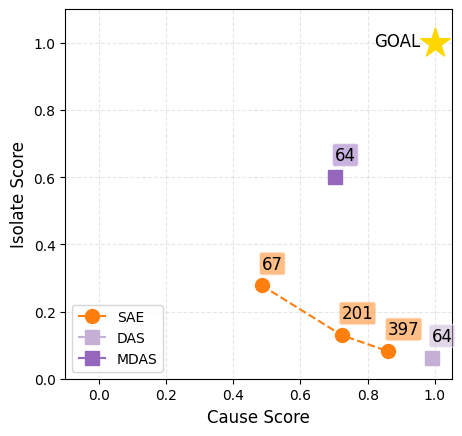

In [37]:
#@markdown Plotting

import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100


colors = [matplotlib.colors.to_hex(c) for c in plt.cm.tab20.colors]

name_to_color = {
    'SAE_RAND': 'gray',
    'PCA': colors[6],
    'SAE': colors[2],
    'RLAP': colors[4],
    'DBM': colors[1],
    'MDBM': colors[0],
    'DAS': colors[9],
    'MDAS': colors[8],
}

name_to_marker = {
    'SAE_RAND': 'o--',
    'PCA': 'o--',
    'SAE': 'o--',
    'RLAP': '^--',
    'DBM': 's--',
    'MDBM': 's--',
    'DAS': 's--',
    'MDAS': 's--',
}

for n, x in method_to_data.items():
    # sorted_dim = sorted(x, key=lambda i: float(i[:-1]))
    sorted_dim = sorted(x, key=lambda i: int(i))
    p = plt.plot(
        [x[k]['cause'] for k in sorted_dim],
        [x[k]['isolate'] for k in sorted_dim], name_to_marker[n], label=n, markersize=10,
        c=name_to_color[n]
    )
    for k in sorted(x, key=lambda s: x[s]['disentangle'], reverse=True):
      c = p[-1].get_color()
      offset = (0, 0.05)
      # Shift text boxes to avoid overlaps.
      if n == 'SAE' and k == '3.8%':
        offset = (0.05, -0.07)
      plt.annotate(
          k, 
          (x[k]['cause'] - offset[0], x[k]['isolate'] + offset[1]), 
          size=12,
          bbox=dict(boxstyle='round,pad=0.15', fc=c, ec='white', alpha=0.5)
      )
plt.scatter(1, 1, s=500, marker='*', color='gold', zorder=3)
plt.annotate('GOAL', (1.0-0.18, 1.0 - 0.01), size=12)
plt.gca().set_aspect('equal')
plt.xlim(-0.1, 1.05)
plt.ylim(-0.0, 1.1)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(loc = 'lower left', prop={'size': 10})
plt.xlabel('Cause Score', fontsize=12)
_ = plt.ylabel('Isolate Score', fontsize=12)